<a href="https://colab.research.google.com/github/simasaadi/permit-to-take-water-ontario/blob/main/02_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 – Data Cleaning and Feature Engineering

This notebook prepares the Permit to Take Water (PTTW) dataset for deeper analysis and visualization.  
The goal here is not exploration, but **building a clean, structured, analysis-ready dataset** that downstream notebooks and the Streamlit app can rely on without re-doing preprocessing steps.

### What this notebook does

**1. Load the raw CSV file**  
I start from the unmodified source data (`data/raw/PermitsToTakeWater.csv`) to ensure full reproducibility.  
Parquet files created in earlier sessions are not used, since they do not persist across Colab environments.

**2. Standardize column names**  
Different naming conventions (spaces, slashes, punctuation, inconsistent casing) are normalized into a clean, `snake_case` format.  
This makes filtering, modeling, and visualization consistent across the entire project.

**3. Parse and validate date fields**  
Columns such as IssuedDate, ExpiryDate, and RenewDate are converted into proper datetime objects.  
This enables time-based analytics, duration calculations, and trend analysis.

**4. Clean and validate numeric fields**  
Key intensity measures (litres/day, litres/minute, hours/day, days/year) are converted to numeric types.  
Impossible or invalid values are handled appropriately to avoid misleading downstream results.

**5. Engineer meaningful analytical features**  
To support richer insights, we create several domain-relevant variables:
- **Annual permitted volume** (litres/year and m³/year)  
- **Permit duration** (days and years)  
- **Surface vs. groundwater flags**  
- Other normalized fields that help with grouping, filtering, and dashboard visuals

These engineered features make the dataset more interpretable and more powerful in analysis.

**6. Clean categorical fields**  
Purpose categories, water source types, and status flags (e.g., ACTIVE) are cleaned and standardized for accurate grouping and visualization.

**7. Remove exact duplicate records**  
This ensures our analytics reflect unique permits rather than repeated entries.

**8. Build a streamlined analysis dataset**  
A curated subset of the most relevant fields is extracted into `pttw_analysis_ready`.  
This smaller, well-structured dataset is easier to load in notebooks, use for modeling, and pass into the Streamlit dashboard.

**9. Save the cleaned dataset**  
I export the final result in both `.csv` and `.parquet` formats under `data/processed/`.  
These files become the foundation for all advanced analyses in the next notebooks.

---

This notebook transforms messy, raw administrative data into a consistent and enriched dataset suitable for senior-level analytical work, including spatial analysis, sector profiling, and interactive dashboards.


In [1]:
import os

os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

os.listdir()


['.config', 'data', 'sample_data']

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)

sns.set(style="whitegrid")


In [5]:
import pandas as pd
import numpy as np

# Load directly from the raw CSV
DATA_PATH = "data/raw/PermitsToTakeWater.csv"

pttw = pd.read_csv(DATA_PATH, encoding="latin1")
print("Shape:", pttw.shape)
pttw.head()


Shape: (66003, 28)


,PermitNo,ClientName,PurposeCat,SPurpose,ExpiryDate,IssuedDate,RenewDate,OldCtyTwn,P_Lot,P_Con,P_Municip,P_UpperT,P_LowerT,SurfGrnd,SourceID,Easting,Northing,UTMZone,MaxL_Day,Days_Year,Hrs_DayMax,L_Minute,Amended_by,Expired_by,Permit_End,ACTIVE,LATITUDE,LONGITUDE
0,0000-75EL6R,Dee Jay Camps Limited,Dewatering Construction,Construction,09/28/2007,08/10/2007,,OldCT not entered,26,,Wasaga Beach,County of Simcoe,,Ground Water,Wellpoint System,580422,4928153,17,400000.0,30.0,24.0,277.0,7463-77ERKL,,39353.0,No,44.502216,-79.988337
1,0000-AZXQE2,Carlex Corporation Inc. as general partner for...,Construction,Other - Construction,09/30/2018,06/26/2018,,OldCT not entered,19km upstream (south of the Town of Smooth Roc...,3,Smooth Rock Falls,District of Cochrane,,Surface Water,Mattagami River,455179,5441181,17,201600.0,363.0,24.0,140.0,,,43373.0,No,49.121831,-81.614291
2,0000-BP7UPH,The Regional Municipality of Waterloo,Dewatering Construction,Construction,04/30/2023,05/04/2020,,OldCT not entered,Fischer Hallman Rd,,Kitchener,Regional Municipality of Waterloo,,Ground Water,MH7 to MH88A,540833,4805376,17,2745000.0,365.0,24.0,1906.0,,,NaN,Yes,43.400152,-80.495749
3,0001-8X8P7E,,Agricultural,Field and Pasture Crops,08/15/2022,08/16/2012,,OldCT not entered,,,Malahide,County of Elgin,,Ground Water,Farm Pond,506219,4737385,17,240480.0,60.0,24.0,167.0,,,NaN,Yes,42.788983,-80.923961
4,0001-9RHKU6,Ducks Unlimited Canada,Recreational,Wetlands,09/30/2024,01/12/2015,,OldCT not entered,15-Dec,,Hamilton,NaN,,Surface Water,Pond 1,592212,4773461,17,14112000.0,365.0,24.0,9800.0,,,42458.0,No,43.108267,-79.866693


In [6]:
date_cols_original = ["IssuedDate", "ExpiryDate", "RenewDate", "Permit_End"]

for col in date_cols_original:
    if col in pttw.columns:
        pttw[col] = pd.to_datetime(pttw[col], errors="coerce")

pttw[date_cols_original].head()


/tmp/ipython-input-1833653979.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pttw[col] = pd.to_datetime(pttw[col], errors="coerce")


,IssuedDate,ExpiryDate,RenewDate,Permit_End
0,2007-08-10,2007-09-28,NaT,1970-01-01 00:00:00.000039353
1,2018-06-26,2018-09-30,NaT,1970-01-01 00:00:00.000043373
2,2020-05-04,2023-04-30,NaT,NaT
3,2012-08-16,2022-08-15,NaT,NaT
4,2015-01-12,2024-09-30,NaT,1970-01-01 00:00:00.000042458


In [7]:
# Keep a copy of original columns in case we need them
original_columns = pttw.columns.tolist()

pttw.columns = (
    pttw.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("/", "_", regex=False)
    .str.replace("-", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.lower()
)

pttw.columns.tolist()


['permitno',
 'clientname',
 'purposecat',
 'spurpose',
 'expirydate',
 'issueddate',
 'renewdate',
 'oldctytwn',
 'p_lot',
 'p_con',
 'p_municip',
 'p_uppert',
 'p_lowert',
 'surfgrnd',
 'sourceid',
 'easting',
 'northing',
 'utmzone',
 'maxl_day',
 'days_year',
 'hrs_daymax',
 'l_minute',
 'amended_by',
 'expired_by',
 'permit_end',
 'active',
 'latitude',
 'longitude']

In [8]:
rename_map = {
    "maxl_day": "max_l_per_day",
    "days_year": "days_per_year",
    "hrs_daymax": "max_hours_per_day",
    "l_minute": "l_per_minute",
    "issueddate": "issued_date",
    "expirydate": "expiry_date",
    "renewdate": "renew_date",
    "permit_end": "permit_end_date",
    "surfgrnd": "surface_or_ground",
    "purposecat": "purpose_category",
    "spurpose": "specific_purpose"
    # add more here if you see ugly names
}

pttw = pttw.rename(columns=rename_map)
pttw.head()


,permitno,clientname,purpose_category,specific_purpose,expiry_date,issued_date,renew_date,oldctytwn,p_lot,p_con,p_municip,p_uppert,p_lowert,surface_or_ground,sourceid,easting,northing,utmzone,max_l_per_day,days_per_year,max_hours_per_day,l_per_minute,amended_by,expired_by,permit_end_date,active,latitude,longitude
0,0000-75EL6R,Dee Jay Camps Limited,Dewatering Construction,Construction,2007-09-28,2007-08-10,NaT,OldCT not entered,26,,Wasaga Beach,County of Simcoe,,Ground Water,Wellpoint System,580422,4928153,17,400000.0,30.0,24.0,277.0,7463-77ERKL,,1970-01-01 00:00:00.000039353,No,44.502216,-79.988337
1,0000-AZXQE2,Carlex Corporation Inc. as general partner for...,Construction,Other - Construction,2018-09-30,2018-06-26,NaT,OldCT not entered,19km upstream (south of the Town of Smooth Roc...,3,Smooth Rock Falls,District of Cochrane,,Surface Water,Mattagami River,455179,5441181,17,201600.0,363.0,24.0,140.0,,,1970-01-01 00:00:00.000043373,No,49.121831,-81.614291
2,0000-BP7UPH,The Regional Municipality of Waterloo,Dewatering Construction,Construction,2023-04-30,2020-05-04,NaT,OldCT not entered,Fischer Hallman Rd,,Kitchener,Regional Municipality of Waterloo,,Ground Water,MH7 to MH88A,540833,4805376,17,2745000.0,365.0,24.0,1906.0,,,NaT,Yes,43.400152,-80.495749
3,0001-8X8P7E,,Agricultural,Field and Pasture Crops,2022-08-15,2012-08-16,NaT,OldCT not entered,,,Malahide,County of Elgin,,Ground Water,Farm Pond,506219,4737385,17,240480.0,60.0,24.0,167.0,,,NaT,Yes,42.788983,-80.923961
4,0001-9RHKU6,Ducks Unlimited Canada,Recreational,Wetlands,2024-09-30,2015-01-12,NaT,OldCT not entered,15-Dec,,Hamilton,NaN,,Surface Water,Pond 1,592212,4773461,17,14112000.0,365.0,24.0,9800.0,,,1970-01-01 00:00:00.000042458,No,43.108267,-79.866693


In [9]:
date_cols = ["issued_date", "expiry_date", "renew_date", "permit_end_date"]

for col in date_cols:
    if col in pttw.columns:
        pttw[col] = pd.to_datetime(pttw[col], errors="coerce")

pttw[date_cols].head()


,issued_date,expiry_date,renew_date,permit_end_date
0,2007-08-10,2007-09-28,NaT,1970-01-01 00:00:00.000039353
1,2018-06-26,2018-09-30,NaT,1970-01-01 00:00:00.000043373
2,2020-05-04,2023-04-30,NaT,NaT
3,2012-08-16,2022-08-15,NaT,NaT
4,2015-01-12,2024-09-30,NaT,1970-01-01 00:00:00.000042458


In [10]:
pttw[["issued_date", "expiry_date"]].agg(["min", "max"])


,issued_date,expiry_date
min,1960-04-25,1962-12-31
max,2135-09-08,2048-04-09


In [11]:
numeric_cols = ["max_l_per_day", "days_per_year", "max_hours_per_day", "l_per_minute"]

pttw[numeric_cols] = pttw[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Replace negative or zero volumes with NaN (they don't make physical sense)
pttw.loc[pttw["max_l_per_day"] <= 0, "max_l_per_day"] = np.nan

pttw[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
max_l_per_day,64272.0,3.690188e+08,7.032137e+10,6.0,327312.0,1090000.0,3014398.75,1.780000e+13
days_per_year,66003.0,1.698821e+02,2.096020e+02,0.0,20.0,122.0,365.00,3.651500e+04
max_hours_per_day,66003.0,7.012652e+01,1.001430e+04,0.0,12.0,24.0,24.00,2.498364e+06
l_per_minute,66003.0,6.598476e+05,1.068974e+08,0.0,227.5,1138.0,2955.00,2.700000e+10


In [12]:
# Litres per year
pttw["max_l_per_year"] = pttw["max_l_per_day"] * pttw["days_per_year"]

# Convert to cubic metres (1 m3 = 1000 L)
pttw["max_m3_per_day"] = pttw["max_l_per_day"] / 1000
pttw["max_m3_per_year"] = pttw["max_l_per_year"] / 1000

pttw[["max_l_per_day", "days_per_year", "max_m3_per_year"]].head()


,max_l_per_day,days_per_year,max_m3_per_year
0,400000.0,30.0,12000.0
1,201600.0,363.0,73180.8
2,2745000.0,365.0,1001925.0
3,240480.0,60.0,14428.8
4,14112000.0,365.0,5150880.0


In [13]:
# Duration between issue and expiry in days/years
pttw["permit_duration_days"] = (pttw["expiry_date"] - pttw["issued_date"]).dt.days
pttw["permit_duration_years"] = pttw["permit_duration_days"] / 365.25

pttw[["issued_date", "expiry_date", "permit_duration_years"]].head()


,issued_date,expiry_date,permit_duration_years
0,2007-08-10,2007-09-28,0.134155
1,2018-06-26,2018-09-30,0.262834
2,2020-05-04,2023-04-30,2.986995
3,2012-08-16,2022-08-15,9.995893
4,2015-01-12,2024-09-30,9.716632


In [14]:
pttw["surface_or_ground"].value_counts(dropna=False)


,count
surface_or_ground,
Ground Water,28769
Surface Water,22169
Surface and Ground Water,13036
Pumping Test,1792
,237


In [15]:
pttw["is_surface_water"] = np.where(pttw["surface_or_ground"].str.upper().str.startswith("S"), 1, 0)
pttw["is_groundwater"] = np.where(pttw["surface_or_ground"].str.upper().str.startswith("G"), 1, 0)

pttw[["surface_or_ground", "is_surface_water", "is_groundwater"]].head()


,surface_or_ground,is_surface_water,is_groundwater
0,Ground Water,0,1
1,Surface Water,1,0
2,Ground Water,0,1
3,Ground Water,0,1
4,Surface Water,1,0


In [16]:
cat_cols = ["purpose_category", "specific_purpose", "active", "surface_or_ground"]

for col in cat_cols:
    if col in pttw.columns:
        pttw[col] = (
            pttw[col]
            .astype("string")
            .str.strip()
        )

# Example: normalize ACTIVE column to Yes/No
if "active" in pttw.columns:
    pttw["active"] = pttw["active"].str.title()  # "Yes", "No", etc.
    pttw["active"].value_counts(dropna=False)


In [17]:
if "permitno" in pttw.columns:
    dup_counts = pttw["permitno"].value_counts()
    dup_counts.head()


In [18]:
before = pttw.shape[0]
pttw = pttw.drop_duplicates()
after = pttw.shape[0]

print(f"Removed {before - after} exact duplicate rows.")


Removed 309 exact duplicate rows.


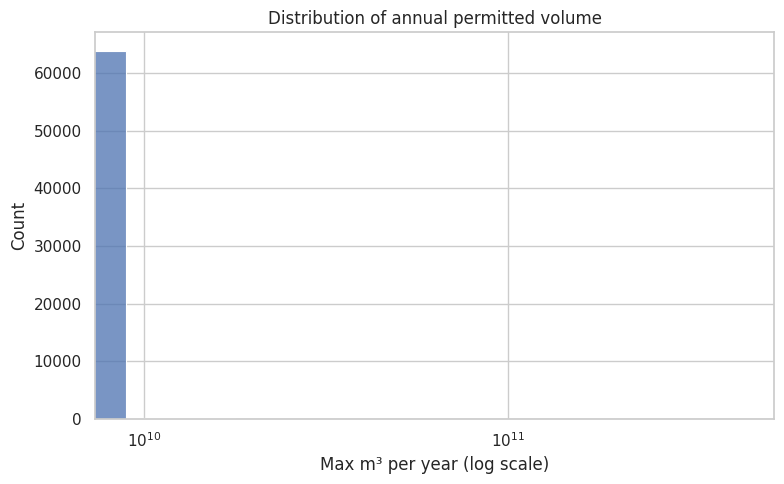

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(pttw["max_m3_per_year"], bins=50)
plt.xscale("log")
plt.xlabel("Max m³ per year (log scale)")
plt.title("Distribution of annual permitted volume")
plt.tight_layout()
plt.show()


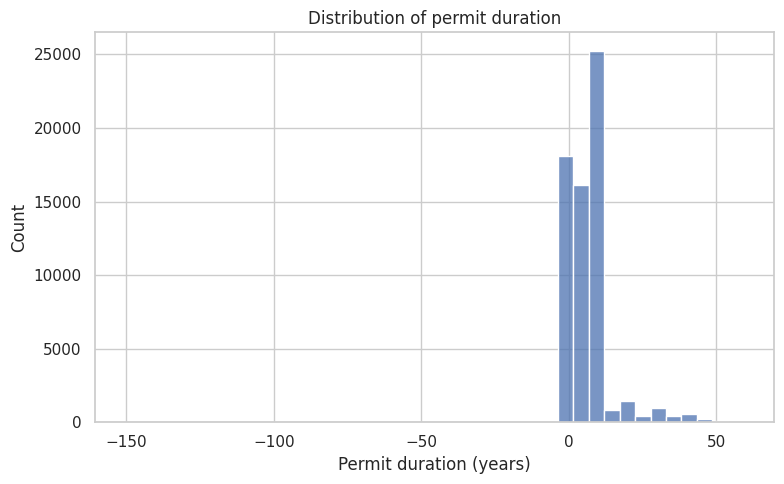

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(pttw["permit_duration_years"], bins=40)
plt.xlabel("Permit duration (years)")
plt.title("Distribution of permit duration")
plt.tight_layout()
plt.show()


In [22]:
pttw.loc[pttw["permit_duration_years"] > 50, "permit_duration_years"] = np.nan


In [23]:
core_columns = [
    # identifiers
    "permitno",
    "company",  # or "client_name" etc if present
    "municipality",
    "county",
    "watershed",  # if you have such columns
    "subwatershed",

    # location
    "latitude",
    "longitude",

    # status & categories
    "active",
    "purpose_category",
    "specific_purpose",
    "surface_or_ground",
    "is_surface_water",
    "is_groundwater",

    # volumes
    "max_l_per_day",
    "days_per_year",
    "max_l_per_year",
    "max_m3_per_day",
    "max_m3_per_year",

    # time
    "issued_date",
    "expiry_date",
    "renew_date",
    "permit_end_date",
    "permit_duration_days",
    "permit_duration_years"
]

# Keep only those that actually exist in this dataset
core_columns = [c for c in core_columns if c in pttw.columns]

pttw_core = pttw[core_columns].copy()
pttw_core.head()


,permitno,latitude,longitude,active,purpose_category,specific_purpose,surface_or_ground,is_surface_water,is_groundwater,max_l_per_day,days_per_year,max_l_per_year,max_m3_per_day,max_m3_per_year,issued_date,expiry_date,renew_date,permit_end_date,permit_duration_days,permit_duration_years
0,0000-75EL6R,44.502216,-79.988337,No,Dewatering Construction,Construction,Ground Water,0,1,400000.0,30.0,1.200000e+07,400.00,12000.0,2007-08-10,2007-09-28,NaT,1970-01-01 00:00:00.000039353,49.0,0.134155
1,0000-AZXQE2,49.121831,-81.614291,No,Construction,Other - Construction,Surface Water,1,0,201600.0,363.0,7.318080e+07,201.60,73180.8,2018-06-26,2018-09-30,NaT,1970-01-01 00:00:00.000043373,96.0,0.262834
2,0000-BP7UPH,43.400152,-80.495749,Yes,Dewatering Construction,Construction,Ground Water,0,1,2745000.0,365.0,1.001925e+09,2745.00,1001925.0,2020-05-04,2023-04-30,NaT,NaT,1091.0,2.986995
3,0001-8X8P7E,42.788983,-80.923961,Yes,Agricultural,Field and Pasture Crops,Ground Water,0,1,240480.0,60.0,1.442880e+07,240.48,14428.8,2012-08-16,2022-08-15,NaT,NaT,3651.0,9.995893
4,0001-9RHKU6,43.108267,-79.866693,No,Recreational,Wetlands,Surface Water,1,0,14112000.0,365.0,5.150880e+09,14112.00,5150880.0,2015-01-12,2024-09-30,NaT,1970-01-01 00:00:00.000042458,3549.0,9.716632


In [24]:
processed_dir = "data/processed"
os.makedirs(processed_dir, exist_ok=True)

clean_path_parquet = os.path.join(processed_dir, "pttw_analysis_ready.parquet")
clean_path_csv = os.path.join(processed_dir, "pttw_analysis_ready.csv")

pttw_core.to_parquet(clean_path_parquet, index=False)
pttw_core.to_csv(clean_path_csv, index=False)

clean_path_parquet, clean_path_csv


('data/processed/pttw_analysis_ready.parquet',
 'data/processed/pttw_analysis_ready.csv')